# Reinforcement Learning bsed Trading Strategy

In this case study, you will learn how to combine reinforcement learning with time series modeling, in order to predict the prices of stocks, based on real-life data.


The focus of this notebook are as follows:
* Build a Trading strategy based on reinforcement learning from scratch.
* Train using the test data followed by testing.
* Evaluate Acto-Critic Method of reinforcement learning which is a combination of policy and value based reinforcement learning. 
* Understand approaches to understand the reinfrocement learning algorithms and fine tune them.
* Class Structure of python programming. Mentioned step by step in the jupyter notebook.


## Content

* [1. Introduction](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1) 
* [5.Evaluate Algorithms and Models](#5)        
    * [5.1. Actor Script](#5.1)
    * [5.2. Critic Script](#5.2)
    * [5.3. Agent Script](#5.3)
    * [5.4. Helper Function](#5.4)
    * [5.5. Training Set](#5.5)       
* [6.Test Set](#6)           

<a id='0'></a>
# 1. Introduction

In this jupyter notebook, we will look at the following Reinforcement Learning Techniques:
1. Actor Critic


Our solution uses an actor-critic reinforcement learning model, along with an infused time series, to help us predict the best action, based on the stock prices. The possible actions are as follows:

**ACTION**

* Hold: This means that based on the price and projected profit, the trader should hold a stock
* Sell: This means that based on the price and projected profit, the trader should sell a stock
* Buy: This means that based on the price and projected profit, the trader should buy a stock

**POLICY**

The actor-critic network is a family of reinforcement learning methods premised on two interacting network models. These models have two components: the actor and the critic. In our case, the network models that we will use will be neural networks. We will use the Keras package, which you have already learned about, to create the neural networks. The reward function that we are looking to improve is the profit.

The actor takes in the state of the environment, then returns the best action, or a policy that refers to a probability distribution over actions. This seems like a natural way to perform reinforcement learning, as policies are directly returned as a function of the state.

The critic evaluates the actions returned by the actor-network. This is similar to the traditional deep Q network; in the environment state and an action to return a score representing the value of taking that action given the state. The job of the critic is to compute an approximation, which is then used to update the actor in the direction of its gradient. The critic is trained itself temporal difference algorithm.

These two networks are trained simultaneously. With time, the critic network is able to improve its Q_value prediction, and the actor also learns how to make better decisions, given the state.

There are five scripts that make up this solution, and they will be described in the next sections.

**ENVIRONMENT**

Stock Market 


**SCRIPT**

We will look at the following Scripts :

1. Actor Script
2. Critic Script
3. Agent script

Additional:
4. Helper Function

**DATA**


The data that we will use will be the standard and poor's 500. According to Wikipedia, it is An American stock market index based on the market capitalizations of 500 large companies having common stock listed on the NYSE or NASDAQ. Here is a link to the data (https://ca.finance.yahoo.com/quote/%255EGSPC/history?p=%255EGSPC).

## Agent

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [32]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import pandas_datareader as dr
import math
from numpy.random import choice
import random

#Import Model Packages for reinforcement learning
from keras import layers, models, optimizers
from keras import backend as K
from collections import namedtuple, deque

<a id='1.2'></a>
## 2.2. Loading the Data

In [33]:
#The data already obtained from yahoo finance is imported.
dataset = read_csv('data/^GSPC.csv',index_col=0)

In [34]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [35]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [36]:
# shape
dataset.shape

(2515, 6)

In [44]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,1320.28,1320.28,1276.05,1283.27,1283.27,1129400000
2001-01-03,1283.27,1347.76,1274.62,1347.56,1347.56,1880700000
2001-01-04,1347.56,1350.24,1329.14,1333.34,1333.34,2131000000
2001-01-05,1333.34,1334.77,1294.95,1298.35,1298.35,1430800000
2001-01-08,1298.35,1298.35,1276.29,1295.86,1295.86,1115500000


The data has the following columns:

* Date: This indicates the date under consideration

* Open: This indicates the price at which the market opens on the date

* High: This indicates the highest market price on the date

* Low: This indicates the lowest market price on the date

* Close: This indicates the price at which the market closes on the date, adjusted for the split

* Adj Close: This indicates the adjusted closing price for both the split and dividends

* Volume: This indicates the total volume of shares available

In [45]:
# describe data
set_option('precision', 3)
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2515.000,2515.000,2515.000,2515.000,2515.000,2.515e+03
mean,1158.443,1166.482,1149.707,1158.473,1158.473,2.822e+09
std,181.226,180.263,182.188,181.187,181.187,1.774e+09
min,679.280,695.270,666.790,676.530,676.530,3.561e+08
25%,1049.605,1058.805,1042.390,1049.985,1049.985,1.420e+09
50%,1154.050,1161.160,1144.940,1154.050,1154.050,2.153e+09
75%,1272.725,1280.355,1265.475,1272.875,1272.875,4.022e+09
max,1564.980,1576.090,1555.460,1565.150,1565.150,1.146e+10


<a id='3'></a>
## 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning
Check for the NAs in the rows, either drop them or fill them with the mean of the column

In [46]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


In case there are null values fill the missing values with the last value available in the dataset. 

In [47]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')
dataset.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,1320.28,1320.28,1276.05,1283.27,1283.27,1129400000
2001-01-03,1283.27,1347.76,1274.62,1347.56,1347.56,1880700000


The parameters to clusters are the indices and the variables used in the clustering are the columns. Hence the data is in the right format to be fed to the clustering algorithms

<a id='4'></a>
# 5. Evaluate Algorithms and Models

We will look at the following Scripts :

1. Actor Script
2. Critic Script
3. Agent script

Additional:
4. Helper Function

<a id='5.1'></a>
## 5.1. Actor Script

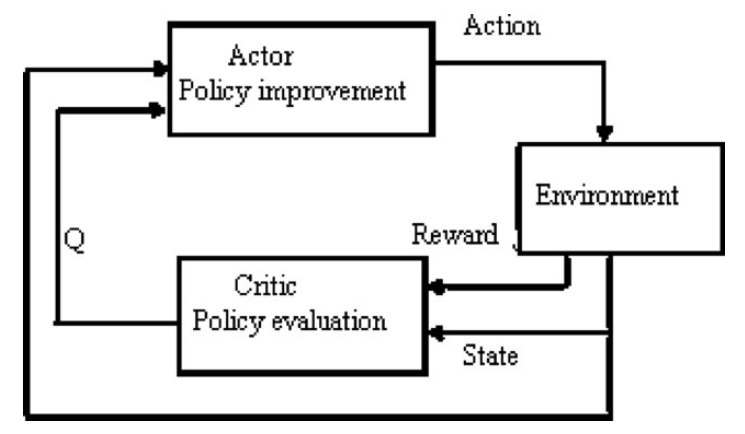

The actor script is where the policy model is defined. We begin by importing certain modules from Keras: layers, optimizers, models, and the backend. These modules will help us to construct our neural network: Let's start by importing the required functions from Keras.



Given that splitting a class between different cells is not very robust the details of the function in the class is described below:

* We create a class called Actor, whose object takes in the parameters of the state and action size which represent the dimension of the state and action respectively. 

* In the next step we call the build function to build the model.Build a policy model that maps the states to actions, and start by defining the input layer

* Add hidden layers to the model. There are two dense layers, each one followed by a batch normalization and an activation layer. The dense layers are regularized. The two layers have 16 and 32 hidden units.

* The final output layer will predict the action probabilities that have an activation of softmax:

* Define the loss function by using the action value (Q_value) gradients

* Define the optimizer and training function

The custom training function for the actor-network that makes use of the Q gradients with respect to the action probabilities. With this custom function, the training aims to maximize the profits (in other words, minimize the negatives of the Q_values).


In [48]:
class Actor:
    
    
  # """Actor (policy) Model. """

    def __init__(self, state_size, action_size):

        self.state_size = state_size
        self.action_size = action_size

        self.build_model()

    def build_model(self):
        states = layers.Input(shape=(self.state_size,), name='states')
        
        net = layers.Dense(units=16,kernel_regularizer=layers.regularizers.l2(1e-6))(states)
        net = layers.BatchNormalization()(net)
        net = layers.Activation("relu")(net)
        net = layers.Dense(units=32,kernel_regularizer=layers.regularizers.l2(1e-6))(net)
        net = layers.BatchNormalization()(net)
        net = layers.Activation("relu")(net)

        actions = layers.Dense(units=self.action_size, activation='softmax', name = 'actions')(net)
        
        self.model = models.Model(inputs=states, outputs=actions)

        action_gradients = layers.Input(shape=(self.action_size,))
        loss = K.mean(-action_gradients * actions)

        optimizer = optimizers.Adam(lr=.00001)
        updates_op = optimizer.get_updates(params=self.model.trainable_weights, loss=loss)
        self.train_fn = K.function(
            inputs=[self.model.input, action_gradients, K.learning_phase()],
            outputs=[],
            updates=updates_op)

<a id='5.2'></a>
## 5.2. Critic Script

The steps for the Critic Script are as follows:     
    
* We begin by importing certain modules from Keras: layers, optimizers, models, and the backend. These modules will help us to construct our neural network:
* We create a class called Critic, whose object takes in the following parameters:
* Build a critic (value) network that maps state and action pairs (Q_values), and define input layers, as follows:
* Add the hidden layers for the state pathway
* Combine the state and action pathways
* Add the final output layer to produce the action values (Q_values).
* Create the Keras model
* Define the optimizer and compile a model for training with the built-in loss function
* Compute the action gradients (the derivative of Q_values, with respect to actions)
* Define an additional function to fetch the action gradients (to be used by the actor model)


In [49]:
from keras import layers, models, optimizers
from keras import backend as K


class Critic:
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
        """
        self.state_size = state_size
        self.action_size = action_size

        self.build_model()

    def build_model(self):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        # Define input layers
        states = layers.Input(shape=(self.state_size,), name='states')
        actions = layers.Input(shape=(self.action_size,), name='actions')

        net_states = layers.Dense(units=16,kernel_regularizer=layers.regularizers.l2(1e-6))(states)
        net_states = layers.BatchNormalization()(net_states)
        net_states = layers.Activation("relu")(net_states)

        net_states = layers.Dense(units=32, kernel_regularizer=layers.regularizers.l2(1e-6))(net_states)

        net_actions = layers.Dense(units=32,kernel_regularizer=layers.regularizers.l2(1e-6))(actions)

        net = layers.Add()([net_states, net_actions])
        net = layers.Activation('relu')(net)

        Q_values = layers.Dense(units=1, name='q_values',kernel_initializer=layers.initializers.RandomUniform(minval=-0.003, maxval=0.003))(net)

        self.model = models.Model(inputs=[states, actions], outputs=Q_values)

        optimizer = optimizers.Adam(lr=0.001)
        self.model.compile(optimizer=optimizer, loss='mse')

        action_gradients = K.gradients(Q_values, actions)

        self.get_action_gradients = K.function(
            inputs=[*self.model.input, K.learning_phase()],
            outputs=action_gradients)


<a id='5.3'></a>
## 5.3. Agent script

In this section, we will train an agent that will perform reinforcement learning based on the actor and critic networks. We will perform the following steps to achieve this:

* Create an agent class whose initial function takes in the batch size, state size, and an evaluation Boolean function, to check whether the training is ongoing.
* In the agent class, create the following methods:
* Import the actor and critic scripts:
* Create a ReplayBuffer class that adds, samples, and evaluates a buffer:
* Add a new experience to the replay buffer memory
* Randomly sample a batch of experienced tuples from the memory. In the following function, we randomly sample states from a memory buffer. We do this so that the states that we feed to the model are not temporally correlated. This will reduce overfitting:
* Return the current size of the buffer memory
* The reinforcement learning agent that learns using the actor-critic network.
* The number of actions are defined as 3: sit, buy, sell
* Define the replay memory size



In [50]:
# from actor import Actor
# from critic import Critic

import numpy as np
from numpy.random import choice
import random
from collections import namedtuple, deque


class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
    
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size        
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    #Randomly sample a batch of experienced tuples from the memory. 
    def sample(self, batch_size=32):
        return random.sample(self.memory, k=self.batch_size)
    
    #Return the current size of the buffer memory
    def __len__(self):
        return len(self.memory)
    
    
class Agent:
    def __init__(self, state_size, batch_size, is_eval = False):
        self.state_size = state_size
        #The number of actions are defined as 3: sit, buy, sell
        self.action_size = 3
        #Define the replay memory size
        self.buffer_size = 1000000
        self.batch_size = batch_size
        self.memory = ReplayBuffer(self.buffer_size, self.batch_size)
        self.inventory = []
        #Define whether or not training is ongoing. This variable will be changed during the training and evaluation phase
        self.is_eval = is_eval
        
        #Discount factor in Bellman equation:
        self.gamma = 0.99
        #A soft update of the actor and critic networks can be done as follows:
        self.tau = 0.001
        
        #The actor policy model maps states to actions 
        #and instantiates the actor networks (local and target models, for soft updates of parameters):
        
        self.actor_local = Actor(self.state_size, self.action_size)
        self.actor_target = Actor(self.state_size, self.action_size)    
        
        #The critic (value) model that maps the state-action pairs to Q_values is as follows
        self.critic_local = Critic(self.state_size, self.action_size)
        
        #Instantiate the critic model (the local and target models are utilized to allow for soft updates), as follows:
        self.critic_target = Critic(self.state_size, self.action_size)
        
        #The following code sets the target model parameters to local model parameters        
        self.critic_target.model.set_weights(self.critic_local.model.get_weights()) 
        self.actor_target.model.set_weights(self.actor_local.model.get_weights())
     
    # Returnsan action, given a state, using the actor (policy network) and the output of 
    # the softmax layer of the actor-network, returning the probability for each action. 
    # An action method that returns an action, given a state, using the actor (policy network) is as follows:
    
    def act(self, state):
        options = self.actor_local.model.predict(state)
        self.last_state = state
        if not self.is_eval:
            return choice(range(3), p = options[0])
        return np.argmax(options[0])
    
    # Returns a stochastic policy, based on the action probabilities in the training model 
    # and a deterministic action corresponding to the maximum probability during testing. 
    # There is a set of actions to be carried out by the agent at every step of the episode. 
    # A method (step) that returns the set of actions to be carried out by the agent at every 
    # step of the episode is as follows:
        
    def step(self, action, reward, next_state, done):
        # The following code adds a new experience to the memory:
        self.memory.add(self.last_state, action, reward, next_state, done)
        # The following code asserts that enough experiences are present in the memory to train:
        if len(self.memory) > self.batch_size:
            #The following code samples a random batch from the memory to train:
            experiences = self.memory.sample(self.batch_size)
            # Learn from the sampled experiences, as follows:
            self.learn(experiences)
            # The following code updates the state to the next state:
            self.last_state = next_state
            
            
    # Learning from the sampled experiences through the actor and the critic. 
    # Create a method to learn from the sampled experiences through the actor and the critic, as follows:
    def learn(self, experiences):               
        states = np.vstack([e.state for e in experiences if e is not None]).astype(np.float32).reshape(-1,self.state_size)    
        actions = np.vstack([e.action for e in experiences if e is not None]).astype(np.float32).reshape(-1,self.action_size)
        rewards = np.array([e.reward for e in experiences if e is not None]).astype(np.float32).reshape(-1,1)
        dones = np.array([e.done for e in experiences if e is not None]).astype(np.float32).reshape(-1,1)
        next_states = np.vstack([e.next_state for e in experiences if e is not None]).astype(np.float32).reshape(-1,self.state_size)
        
        # Return a separate array for each experience in the replay component and 
        # predict actions based on the next states, as follows:
        actions_next = self.actor_target.model.predict_on_batch(next_states)
        
        # Predict the Q_value of the actor output for the next state, as follows:        
        Q_targets_next = self.critic_target.model.predict_on_batch([next_states, actions_next])
        
        #Target the Q_value to serve as a label for the critic network, based on the temporal difference, as follows:
        Q_targets = rewards + self.gamma * Q_targets_next * (1 - dones)
        
        #Fit the critic model to the time difference of the target, as follows:
        self.critic_local.model.train_on_batch(x = [states, actions], y=Q_targets)
        
        # Train the actor model (local) using the gradient of the critic network output with 
        # respect to the action probabilities fed from the actor-network:
        action_gradients = np.reshape(self.critic_local.get_action_gradients([states, actions, 0]),(-1, self.action_size))
        # Next, define a custom training function, as follows:
        self.actor_local.train_fn([states, action_gradients, 1])
        # Next, initiate a soft update of the parameters of both networks, as follows:
        self.soft_update(self.critic_local.model, self.critic_target.model)  
        self.soft_update(self.actor_local.model, self.actor_target.model)
    
    # This performs soft updates on the model parameters, based on the parameter tau to 
    # avoid drastic model changes. A method that updates the model by performing soft updates 
    # on the model parameters, based on the parameter tau (to avoid drastic model changes), is as follows:
    def soft_update(self, local_model, target_model):
        local_weights = np.array(local_model.get_weights())
        target_weights = np.array(target_model.get_weights())

        assert len(local_weights) == len(target_weights)

        new_weights = self.tau * local_weights + (1 - self.tau) * target_weights
        target_model.set_weights(new_weights)

<a id='5.5'></a>
## 5.5. Helper Functions

In [52]:
import numpy as np
import math


def formatPrice(n):
    if n >= 0:
        curr = "$"
    else:
        curr = "-$"
    return curr + "{0:.2f}".format(abs(n))


def getStockData(key):
    datavec = []
    lines = open("data/" + key + ".csv", "r").read().splitlines()
    
    for line in lines[1:]:
        datavec.append(float(line.split(",")[4]))
    
    return datavec
  

def getState(data, t, window):
    if t - window >= -1:
        vec = data[t - window + 1:t + 1]
    else: 
        vec = -(t-window+1)*[data[0]]+data[0: t + 1]
    scaled_state = []
    for i in range(window - 1):
        scaled_state.append(1/(1 + math.exp(vec[i] - vec[i+1])))
    
    return np.array([scaled_state])


<a id='5.6'></a>
## 5.6. Training the data

We will proceed to train the data, based on our agent and helper methods. This will provide us with one of three actions, based on the states of the stock prices at the end of the day. These states can be to buy, sell, or hold. During training, the prescribed action for each day is predicted, and the price (profit, loss, or unchanged) of the action is calculated. The cumulative sum will be calculated at the end of the training period, and we will see whether there has been a profit or a loss. The aim is to maximize the total profit.

Steps: 
* Define the number of market days to consider as the window size and define the batch size with which the neural network will be trained.
* Instantiate the stock agent with the window size and batch size.
* Read the training data from the CSV file, using the helper function.
* The episode count is defined as 10. The agent will look at the data for so many numbers of times. An episode represents a complete pass over the data.
* We can start to iterate through the episodes.
* Each episode has to be started with a state based on the data and window size. The inventory of stocks is initialized before going through the data.
* **Start to iterate over every day of the stock data. The action probability is predicted by the agent**
* Action can be held, if the agent decides not to do anything with the stock. Another possible action is to buy (hence, the stock will be added to the inventory).
* If the action is 2, the agent sells the stocks and removes it from the inventory. Based on the sale, the profit (or loss) is calculated.
        


In [53]:
# from agent import Agent
# from helper import getStockData, getState, formatPrice

# define the number of market days to consider as the window size, 
# and define the batch size with which the neural network will be trained, as follows:
window_size = 50
batch_size = 32
agent = Agent(window_size, batch_size)
data = getStockData("^GSPC")
l = len(data) - 1
episode_count = 10

for e in range(episode_count):
    print("Episode " + str(e) + "/" + str(episode_count))
    state = getState(data, 0, window_size + 1)

    agent.inventory = []
    total_profit = 0
    done = False
    #Next, start to iterate over every day of the stock data. 
    
    
    for t in range(l):
        action = agent.act(state)
        
        action_prob = agent.actor_local.model.predict(state)

        next_state = getState(data, t + 1, window_size + 1)
        reward = 0
        
        #The action can be held, if the agent decides not to do anything with the stock. 
        #Another possible action is to buy (hence, the stock will be added to the inventory), as follows:
        if action == 1:
            agent.inventory.append(data[t])
            print("Buy:" + formatPrice(data[t]))
            
        #If the action is 2, the agent sells the stocks and removes it from the inventory. 
        #Based on the sale, the profit (or loss) is calculated.
        
        elif action == 2 and len(agent.inventory) > 0:
            bought_price = agent.inventory.pop(0)
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            print("sell: " + formatPrice(data[t]) + "| profit: " + formatPrice(data[t] - bought_price))

        if t == l - 1:
            done = True
        agent.step(action_prob, reward, next_state, done)
        state = next_state

        if done:
            print("------------------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("------------------------------------------")

Episode 0/10
Buy:$1333.34
sell: $1298.35| profit: -$34.99
Buy:$1329.47
Buy:$1347.97
sell: $1342.54| profit: $13.07
sell: $1360.40| profit: $12.43
Buy:$1349.47
sell: $1354.31| profit: $4.84
Buy:$1340.89
sell: $1332.53| profit: -$8.36
Buy:$1315.92
Buy:$1301.53
sell: $1278.94| profit: -$36.98
Buy:$1255.27
Buy:$1252.82
sell: $1267.65| profit: -$33.88
Buy:$1239.94
sell: $1241.23| profit: -$14.04
sell: $1234.18| profit: -$18.64
sell: $1253.80| profit: $13.86
Buy:$1166.71
Buy:$1170.81
Buy:$1117.58
Buy:$1139.83
sell: $1152.69| profit: -$14.02
sell: $1153.29| profit: -$17.52
sell: $1147.95| profit: $30.37
sell: $1160.33| profit: $20.50
Buy:$1137.59
sell: $1191.81| profit: $54.22
Buy:$1238.16
Buy:$1253.69
Buy:$1242.98
sell: $1224.36| profit: -$13.80
Buy:$1228.75
sell: $1234.52| profit: -$19.17
sell: $1253.05| profit: $10.07
sell: $1249.46| profit: $20.71
Buy:$1266.61
sell: $1263.51| profit: -$3.10
Buy:$1248.92
Buy:$1284.99
Buy:$1312.83
Buy:$1309.38
sell: $1289.05| profit: $40.13
Buy:$1267.93
Buy

Buy:$1109.78
sell: $1095.40| profit: -$14.38
Buy:$1145.20
sell: $1129.44| profit: -$15.76
Buy:$1118.15
Buy:$1139.93
Buy:$1122.41
Buy:$1107.30
Buy:$1117.49
sell: $1119.55| profit: $1.40
sell: $1121.53| profit: -$18.40
sell: $1113.99| profit: -$8.42
Buy:$1098.70
sell: $1095.45| profit: -$11.85
Buy:$1097.28
sell: $1096.44| profit: -$21.05
Buy:$1095.70
sell: $1084.10| profit: -$14.60
Buy:$1093.56
sell: $1095.41| profit: -$1.87
sell: $1113.05| profit: $17.35
Buy:$1114.94
sell: $1121.28| profit: $27.72
sell: $1120.68| profit: $5.74
Buy:$1140.42
sell: $1142.18| profit: $1.76
Buy:$1136.47
sell: $1125.29| profit: -$11.18
Buy:$1133.56
Buy:$1135.02
sell: $1130.30| profit: -$3.26
Buy:$1140.65
sell: $1136.20| profit: $1.18
sell: $1140.84| profit: $0.19
Buy:$1112.81
sell: $1115.14| profit: $2.33
Buy:$1080.70
Buy:$1079.04
sell: $1064.80| profit: -$15.90
sell: $1095.17| profit: $16.13
Buy:$1104.96
Buy:$1107.77
Buy:$1099.15
sell: $1104.24| profit: -$0.72
Buy:$1118.31
sell: $1113.63| profit: $5.86
sell:

sell: $1531.05| profit: $23.38
Buy:$1533.70
Buy:$1512.84
sell: $1522.19| profit: -$11.51
sell: $1502.56| profit: -$10.28
Buy:$1518.76
sell: $1547.70| profit: $28.94
Buy:$1511.04
Buy:$1458.95
Buy:$1455.27
Buy:$1465.81
sell: $1472.20| profit: -$38.84
sell: $1467.67| profit: $8.72
sell: $1476.71| profit: $21.44
sell: $1497.49| profit: $31.68
Buy:$1411.27
Buy:$1445.94
sell: $1445.55| profit: $34.28
Buy:$1447.12
sell: $1464.07| profit: $18.13
Buy:$1479.37
sell: $1432.36| profit: -$14.76
sell: $1463.76| profit: -$15.61
Buy:$1473.99
sell: $1472.29| profit: -$1.70
Buy:$1525.42
sell: $1531.38| profit: $5.96
Buy:$1535.28
Buy:$1540.98
sell: $1502.17| profit: -$33.11
sell: $1520.27| profit: -$20.71
Buy:$1451.15
sell: $1458.74| profit: $7.59
Buy:$1481.14
sell: $1472.42| profit: -$8.72
Buy:$1462.79
sell: $1507.34| profit: $44.55
Buy:$1515.96
sell: $1477.65| profit: -$38.31
Buy:$1486.59
sell: $1488.41| profit: $1.82
Buy:$1467.95
sell: $1445.90| profit: -$22.05
Buy:$1454.98
sell: $1460.12| profit: $5.

Buy:$1100.64
sell: $1113.57| profit: -$18.58
sell: $1094.44| profit: -$6.20
Buy:$1096.22
sell: $1111.94| profit: $15.72
Buy:$1109.89
Buy:$1106.73
sell: $1131.78| profit: $21.89
sell: $1162.77| profit: $56.04
Buy:$1168.26
sell: $1165.58| profit: -$2.68
Buy:$1151.85
sell: $1153.59| profit: $1.74
Buy:$1144.58
sell: $1136.76| profit: -$7.82
Buy:$1126.34
sell: $1122.73| profit: -$3.61
Buy:$1126.07
sell: $1124.47| profit: -$1.60
Buy:$1065.45
Buy:$1084.56
Buy:$1073.43
sell: $1052.67| profit: -$12.78
Buy:$1073.01
sell: $1054.99| profit: -$29.57
sell: $1097.28| profit: $23.85
sell: $1098.23| profit: $25.22
Buy:$1106.59
sell: $1091.88| profit: -$14.71
Buy:$1049.90
sell: $1027.53| profit: -$22.37
Buy:$1009.56
Buy:$1036.17
sell: $1006.29| profit: -$3.27
sell: $989.14| profit: -$47.03
Buy:$992.72
sell: $973.53| profit: -$19.19
Buy:$953.99
sell: $989.03| profit: $35.04
Buy:$927.37
sell: $921.39| profit: -$5.98
Buy:$819.85
sell: $797.70| profit: -$22.15
Buy:$838.68
sell: $898.96| profit: $60.28
Buy:$

Buy:$1275.53
sell: $1283.03| profit: $19.25
sell: $1292.67| profit: $17.14
Buy:$1289.43
sell: $1294.12| profit: $4.69
Buy:$1278.47
sell: $1272.23| profit: -$6.24
Buy:$1307.25
Buy:$1305.08
sell: $1293.23| profit: -$14.02
Buy:$1302.89
sell: $1300.25| profit: -$4.83
sell: $1294.87| profit: -$8.02
Buy:$1305.93
sell: $1311.56| profit: $5.63
Buy:$1309.72
sell: $1310.61| profit: $0.89
Buy:$1308.12
sell: $1312.25| profit: $4.13
Buy:$1292.08
sell: $1270.32| profit: -$21.76
Buy:$1256.58
sell: $1258.57| profit: $1.99
Buy:$1259.87
sell: $1285.71| profit: $25.84
Buy:$1223.69
Buy:$1230.04
sell: $1256.16| profit: $32.47
sell: $1251.54| profit: $21.50
Buy:$1244.50
sell: $1250.56| profit: $6.06
Buy:$1270.20
Buy:$1280.19
sell: $1270.91| profit: $0.71
sell: $1274.08| profit: -$6.11
Buy:$1267.34
sell: $1272.43| profit: $5.09
Buy:$1268.88
Buy:$1268.40
sell: $1263.20| profit: -$5.68
Buy:$1278.55
sell: $1276.66| profit: $8.26
sell: $1270.92| profit: -$7.63
Buy:$1275.77
sell: $1271.48| profit: -$4.29
Buy:$126

Buy:$1062.00
sell: $1055.69| profit: -$6.31
Buy:$1089.63
sell: $1114.61| profit: $24.98
Buy:$1116.04
sell: $1092.04| profit: -$24.00
Buy:$1022.58
Buy:$1060.27
Buy:$1077.96
sell: $1078.75| profit: $56.17
sell: $1095.17| profit: $34.90
sell: $1096.48| profit: $18.52
Buy:$1113.84
Buy:$1106.13
sell: $1101.53| profit: -$12.31
Buy:$1101.60
Buy:$1125.86
sell: $1120.46| profit: $14.33
sell: $1125.81| profit: $24.21
Buy:$1121.64
sell: $1127.79| profit: $1.93
sell: $1121.06| profit: -$0.58
Buy:$1092.54
sell: $1094.16| profit: $1.62
Buy:$1071.69
sell: $1067.36| profit: -$4.33
Buy:$1104.51
sell: $1098.87| profit: -$5.64
Buy:$1134.28
Buy:$1124.83
sell: $1148.67| profit: $14.39
sell: $1142.16| profit: $17.33
Buy:$1144.73
sell: $1146.24| profit: $1.51
Buy:$1137.03
sell: $1160.75| profit: $23.72
Buy:$1165.32
sell: $1169.77| profit: $4.45
Buy:$1173.81
Buy:$1176.19
sell: $1165.90| profit: -$7.91
sell: $1178.17| profit: $1.98
Buy:$1180.26
sell: $1183.08| profit: $2.82
Buy:$1197.84
sell: $1198.35| profit:

sell: $1079.34| profit: $14.54
Buy:$1081.71
Buy:$1095.17
Buy:$1091.23
sell: $1095.68| profit: $13.97
sell: $1096.19| profit: $1.02
sell: $1104.96| profit: $13.73
Buy:$1105.91
sell: $1118.31| profit: $12.40
Buy:$1123.92
sell: $1125.82| profit: $1.90
Buy:$1129.30
Buy:$1113.56
Buy:$1110.11
sell: $1103.52| profit: -$25.78
sell: $1110.06| profit: -$3.50
sell: $1114.80| profit: $4.69
Buy:$1114.58
sell: $1131.50| profit: $16.92
Buy:$1103.23
sell: $1103.66| profit: $0.43
Buy:$1111.09
sell: $1125.40| profit: $14.31
Buy:$1127.44
sell: $1130.20| profit: $2.76
Buy:$1130.51
sell: $1130.56| profit: $0.05
Buy:$1143.20
sell: $1166.17| profit: $22.97
Buy:$1164.08
Buy:$1162.91
sell: $1173.48| profit: $9.40
sell: $1183.81| profit: $20.90
Buy:$1181.94
sell: $1183.55| profit: $1.61
Buy:$1178.57
Buy:$1173.82
sell: $1191.37| profit: $12.80
Buy:$1190.33
sell: $1191.17| profit: $17.35
sell: $1190.25| profit: -$0.08
Buy:$1205.45
sell: $1209.57| profit: $4.12
Buy:$1213.45
sell: $1213.55| profit: $0.10
Buy:$1202.

sell: $1236.83| profit: -$40.75
Buy:$1242.31
sell: $1267.79| profit: -$7.19
Buy:$1232.04
Buy:$1249.05
sell: $1251.70| profit: $9.39
sell: $1192.70| profit: -$39.34
sell: $1156.39| profit: -$92.66
Buy:$1003.35
Buy:$907.84
Buy:$946.43
Buy:$940.55
sell: $955.05| profit: -$48.30
sell: $896.78| profit: -$11.06
sell: $908.11| profit: -$38.32
sell: $876.77| profit: -$63.78
Buy:$940.51
Buy:$930.09
sell: $954.09| profit: $13.58
sell: $968.75| profit: $38.66
Buy:$850.75
sell: $752.44| profit: -$98.31
Buy:$851.81
sell: $857.39| profit: $5.58
Buy:$896.24
sell: $816.21| profit: -$80.03
Buy:$876.07
sell: $909.70| profit: $33.63
Buy:$870.26
Buy:$842.62
sell: $843.74| profit: -$26.52
sell: $850.12| profit: $7.50
Buy:$825.44
sell: $838.51| profit: $13.07
Buy:$832.23
sell: $845.85| profit: $13.62
Buy:$827.16
sell: $833.74| profit: $6.58
Buy:$789.17
sell: $788.42| profit: -$0.75
Buy:$752.83
sell: $735.09| profit: -$17.74
Buy:$750.74
sell: $756.55| profit: $5.81
Buy:$787.53
sell: $797.87| profit: $10.34
B

sell: $963.59| profit: $13.95
Buy:$993.75
Buy:$985.70
sell: $1004.42| profit: $10.67
sell: $1007.84| profit: $22.14
Buy:$980.59
sell: $990.35| profit: $9.76
Buy:$1002.35
Buy:$1000.30
sell: $1003.27| profit: $0.92
sell: $993.06| profit: -$7.24
Buy:$993.71
sell: $996.73| profit: $3.02
Buy:$996.79
sell: $1002.84| profit: $6.05
Buy:$1029.32
sell: $1025.97| profit: -$3.35
Buy:$1020.24
sell: $1034.35| profit: $14.11
Buy:$1046.57
sell: $1058.53| profit: $11.96
Buy:$1050.35
sell: $1034.15| profit: -$16.20
Buy:$1035.28
sell: $1052.08| profit: $16.80
Buy:$1074.14
sell: $1075.13| profit: $0.99
Buy:$1076.48
sell: $1089.18| profit: $12.70
Buy:$1096.02
Buy:$1094.04
sell: $1095.89| profit: -$0.13
Buy:$1109.48
sell: $1109.64| profit: $15.60
Buy:$1111.92
Buy:$1108.48
Buy:$1122.22
sell: $1123.67| profit: $14.19
sell: $1126.33| profit: $14.41
sell: $1131.92| profit: $23.44
sell: $1127.23| profit: $5.01
Buy:$1143.94
sell: $1141.55| profit: -$2.39
Buy:$1136.03
sell: $1126.52| profit: -$9.51
Buy:$1145.54
Bu

Buy:$1540.08
sell: $1500.63| profit: -$39.45
Buy:$1520.27
Buy:$1475.62
sell: $1474.77| profit: -$45.50
sell: $1453.70| profit: -$21.92
Buy:$1481.05
sell: $1470.58| profit: -$10.47
Buy:$1458.74
sell: $1439.70| profit: -$19.04
Buy:$1440.70
sell: $1428.23| profit: -$12.47
Buy:$1504.66
sell: $1515.96| profit: $11.30
Buy:$1484.46
sell: $1496.45| profit: $11.99
Buy:$1497.66
sell: $1476.27| profit: -$21.39
Buy:$1416.18
sell: $1390.19| profit: -$25.99
Buy:$1409.13
sell: $1420.33| profit: $11.20
Buy:$1333.25
Buy:$1325.19
sell: $1310.50| profit: -$22.75
Buy:$1352.07
sell: $1353.96| profit: $28.77
sell: $1355.81| profit: $3.74
Buy:$1326.45
sell: $1336.91| profit: $10.46
Buy:$1331.29
sell: $1339.13| profit: $7.84
Buy:$1348.86
sell: $1367.21| profit: $18.35
Buy:$1349.99
sell: $1348.78| profit: -$1.21
Buy:$1380.02
sell: $1367.68| profit: -$12.34
Buy:$1320.65
sell: $1308.77| profit: -$11.88
Buy:$1298.42
sell: $1352.99| profit: $54.57
Buy:$1325.76
sell: $1315.22| profit: -$10.54
Buy:$1322.70
sell: $13

sell: $1266.61| profit: -$0.82
sell: $1263.51| profit: $14.93
Buy:$1255.54
sell: $1245.67| profit: -$9.87
Buy:$1289.05
Buy:$1293.17
Buy:$1277.89
sell: $1267.93| profit: -$21.12
Buy:$1255.82
Buy:$1267.11
sell: $1283.57| profit: -$9.60
sell: $1270.03| profit: -$7.86
sell: $1276.96| profit: $21.14
sell: $1264.96| profit: -$2.15
Buy:$1208.43
Buy:$1212.58
Buy:$1237.04
sell: $1225.35| profit: $16.92
sell: $1218.60| profit: $6.02
sell: $1216.76| profit: -$20.28
Buy:$1236.72
sell: $1234.45| profit: -$2.27
Buy:$1181.52
sell: $1208.14| profit: $26.62
Buy:$1202.45
sell: $1214.44| profit: $11.99
Buy:$1202.93
sell: $1205.82| profit: $2.89
Buy:$1204.52
sell: $1211.23| profit: $6.71
Buy:$1215.93
sell: $1220.75| profit: $4.82
Buy:$1214.35
Buy:$1200.48
sell: $1204.40| profit: -$9.95
sell: $1183.43| profit: -$17.05
Buy:$1186.73
sell: $1181.66| profit: -$5.07
Buy:$1179.21
sell: $1161.51| profit: -$17.70
Buy:$1129.03
sell: $1133.58| profit: $4.55
Buy:$1085.78
Buy:$1092.54
sell: $1038.77| profit: -$47.01
s

Buy:$1140.84
Buy:$1128.94
sell: $1125.38| profit: -$15.46
Buy:$1116.21
sell: $1118.33| profit: -$10.61
sell: $1109.11| profit: -$7.10
Buy:$1115.14
sell: $1106.69| profit: -$8.45
Buy:$1096.84
Buy:$1086.20
sell: $1094.83| profit: -$2.01
sell: $1095.42| profit: $9.22
Buy:$1101.72
sell: $1106.62| profit: $4.90
Buy:$1065.22
Buy:$1079.04
sell: $1075.79| profit: $10.57
Buy:$1064.80
sell: $1081.71| profit: $2.67
sell: $1091.23| profit: $26.43
Buy:$1096.19
sell: $1104.96| profit: $8.77
Buy:$1105.09
sell: $1107.77| profit: $2.68
Buy:$1125.82
Buy:$1128.33
Buy:$1120.37
Buy:$1123.50
sell: $1128.55| profit: $2.73
sell: $1122.20| profit: -$6.13
sell: $1129.30| profit: $8.93
sell: $1110.11| profit: -$13.39
Buy:$1114.80
Buy:$1114.58
sell: $1131.50| profit: $16.70
Buy:$1135.17
sell: $1134.48| profit: $19.90
sell: $1142.05| profit: $6.88
Buy:$1130.65
Buy:$1122.14
sell: $1113.65| profit: -$17.00
sell: $1103.29| profit: -$18.85
Buy:$1095.74
sell: $1094.80| profit: -$0.94
Buy:$1125.40
sell: $1127.44| profit

Buy:$1406.70
sell: $1411.27| profit: -$65.44
sell: $1445.94| profit: -$51.55
sell: $1447.12| profit: -$6.52
sell: $1464.07| profit: $57.37
Buy:$1457.64
sell: $1473.99| profit: $16.35
Buy:$1478.55
Buy:$1453.55
sell: $1451.70| profit: -$26.85
Buy:$1471.49
sell: $1471.56| profit: $18.01
sell: $1483.95| profit: $12.46
Buy:$1484.25
Buy:$1476.65
sell: $1529.03| profit: $44.78
sell: $1518.75| profit: $42.10
Buy:$1517.73
sell: $1526.75| profit: $9.02
Buy:$1539.59
sell: $1552.58| profit: $12.99
Buy:$1565.15
Buy:$1562.47
sell: $1554.41| profit: -$10.74
sell: $1561.80| profit: -$0.67
Buy:$1506.33
sell: $1519.59| profit: $13.26
Buy:$1515.88
Buy:$1514.40
sell: $1535.28| profit: $19.40
Buy:$1540.98
sell: $1549.38| profit: $34.98
sell: $1502.17| profit: -$38.81
Buy:$1475.62
Buy:$1453.70
Buy:$1439.18
sell: $1481.05| profit: $5.43
sell: $1470.58| profit: $16.88
sell: $1451.15| profit: $11.97
Buy:$1469.02
sell: $1469.72| profit: $0.70
Buy:$1486.59
sell: $1488.41| profit: $1.82
Buy:$1453.00
sell: $1460.1

sell: $1165.81| profit: $27.11
Buy:$1174.17
sell: $1167.72| profit: $17.48
sell: $1165.73| profit: $6.27
sell: $1166.59| profit: $6.69
sell: $1173.22| profit: -$0.95
Buy:$1173.27
Buy:$1169.43
Buy:$1178.10
sell: $1187.44| profit: $14.17
Buy:$1189.44
sell: $1182.45| profit: $13.02
sell: $1186.44| profit: $8.34
sell: $1194.37| profit: $4.93
Buy:$1210.65
sell: $1211.67| profit: $1.02
Buy:$1197.52
sell: $1207.17| profit: $9.65
Buy:$1205.94
sell: $1208.67| profit: $2.73
Buy:$1212.05
sell: $1183.71| profit: -$28.34
Buy:$1128.15
sell: $1110.88| profit: -$17.27
Buy:$1135.68
sell: $1136.94| profit: $1.26
Buy:$1071.59
sell: $1087.69| profit: $16.10
Buy:$1067.95
Buy:$1103.06
sell: $1089.41| profit: $21.46
Buy:$1070.71
Buy:$1102.83
sell: $1050.47| profit: -$52.59
sell: $1055.69| profit: -$15.02
sell: $1086.84| profit: -$15.99
Buy:$1114.61
sell: $1116.04| profit: $1.43
Buy:$1113.20
Buy:$1092.04
Buy:$1076.76
Buy:$1041.24
sell: $1030.71| profit: -$82.49
sell: $1027.37| profit: -$64.67
sell: $1022.58| 

sell: $884.21| profit: -$68.62
sell: $919.62| profit: -$7.75
Buy:$928.77
sell: $950.70| profit: $44.66
Buy:$937.43
sell: $949.36| profit: $105.93
Buy:$962.70
sell: $940.86| profit: $38.08
Buy:$947.95
Buy:$934.82
Buy:$917.87
Buy:$917.80
sell: $916.07| profit: $81.47
Buy:$879.15
sell: $893.92| profit: $34.35
Buy:$909.45
Buy:$886.91
Buy:$889.81
sell: $869.46| profit: -$36.00
Buy:$843.32
sell: $845.39| profit: -$63.25
Buy:$833.70
sell: $819.29| profit: -$109.48
Buy:$854.95
sell: $827.37| profit: -$110.06
Buy:$815.28
Buy:$847.91
sell: $827.91| profit: -$134.79
sell: $818.95| profit: -$129.00
Buy:$785.28
sell: $798.55| profit: -$136.27
Buy:$776.76
sell: $803.92| profit: -$113.95
Buy:$835.32
sell: $841.44| profit: -$76.36
sell: $860.02| profit: -$19.13
sell: $884.39| profit: -$25.06
sell: $899.72| profit: $12.81
Buy:$890.16
sell: $882.50| profit: -$7.31
sell: $897.65| profit: $54.33
Buy:$890.23
sell: $882.15| profit: $48.45
sell: $885.76| profit: $30.81
Buy:$900.96
sell: $908.35| profit: $93.

Buy:$1111.09
Buy:$1125.40
Buy:$1130.51
Buy:$1143.20
sell: $1161.67| profit: $66.87
sell: $1164.89| profit: $53.80
sell: $1164.08| profit: $38.68
Buy:$1162.91
Buy:$1173.48
sell: $1184.17| profit: $53.66
Buy:$1183.81
Buy:$1175.43
Buy:$1181.94
sell: $1183.55| profit: $40.35
sell: $1170.34| profit: $7.43
sell: $1177.24| profit: $3.76
sell: $1176.94| profit: -$6.87
Buy:$1181.76
Buy:$1178.57
Buy:$1173.82
sell: $1191.37| profit: $15.94
sell: $1190.33| profit: $8.39
Buy:$1191.17
Buy:$1190.25
Buy:$1177.07
sell: $1182.81| profit: $1.05
sell: $1189.24| profit: $10.67
Buy:$1198.68
Buy:$1205.72
Buy:$1203.21
sell: $1194.20| profit: $20.38
sell: $1194.65| profit: $3.48
Buy:$1210.13
sell: $1204.92| profit: $14.67
Buy:$1213.54
sell: $1213.55| profit: $36.48
sell: $1211.92| profit: $13.24
Buy:$1202.08
sell: $1188.05| profit: -$17.67
Buy:$1187.89
sell: $1190.25| profit: -$12.96
Buy:$1182.99
Buy:$1177.45
sell: $1195.98| profit: -$14.15
Buy:$1167.87
sell: $1163.75| profit: -$49.79
Buy:$1168.41
sell: $1174.

sell: $1319.66| profit: $80.46
Buy:$1321.18
sell: $1318.03| profit: $72.03
Buy:$1326.37
sell: $1336.35| profit: $56.16
sell: $1336.59| profit: $65.68
Buy:$1338.88
Buy:$1335.85
sell: $1331.32| profit: $72.72
sell: $1334.11| profit: $99.62
sell: $1350.20| profit: $101.07
Buy:$1349.59
Buy:$1350.66
Buy:$1349.95
Buy:$1362.83
Buy:$1365.62
Buy:$1369.06
sell: $1364.05| profit: $103.14
sell: $1365.80| profit: $102.60
sell: $1366.96| profit: $88.41
Buy:$1368.60
Buy:$1377.02
sell: $1377.38| profit: $100.72
Buy:$1389.08
sell: $1377.34| profit: $97.07
sell: $1377.93| profit: $98.57
Buy:$1377.94
Buy:$1367.81
sell: $1367.34| profit: $95.86
Buy:$1379.78
sell: $1382.84| profit: $116.10
Buy:$1385.72
Buy:$1378.33
Buy:$1380.90
sell: $1384.42| profit: $116.21
Buy:$1393.22
Buy:$1396.57
Buy:$1399.76
sell: $1401.20| profit: $105.77
sell: $1400.50| profit: $103.02
sell: $1402.81| profit: $105.29
sell: $1406.09| profit: $107.27
sell: $1381.96| profit: $85.90
Buy:$1386.72
Buy:$1400.63
Buy:$1409.12
Buy:$1414.76
B

Buy:$1266.69
Buy:$1292.20
Buy:$1271.51
Buy:$1281.66
sell: $1300.68| profit: $85.77
sell: $1282.83| profit: $37.47
Buy:$1277.58
Buy:$1274.98
Buy:$1236.83
sell: $1242.31| profit: -$20.89
Buy:$1267.79
Buy:$1224.51
Buy:$1249.05
sell: $1251.70| profit: -$15.68
Buy:$1192.70
Buy:$1213.60
sell: $1156.39| profit: -$132.80
Buy:$1206.51
Buy:$1255.08
Buy:$1207.09
sell: $1188.22| profit: -$77.85
sell: $1185.87| profit: -$110.45
Buy:$1213.27
sell: $1166.36| profit: -$138.96
Buy:$1161.06
Buy:$1099.23
sell: $1056.89| profit: -$241.31
Buy:$984.94
Buy:$1003.35
sell: $998.01| profit: -$268.68
Buy:$907.84
sell: $946.43| profit: -$345.77
Buy:$940.55
sell: $985.40| profit: -$286.11
Buy:$955.05
sell: $896.78| profit: -$384.88
Buy:$908.11
Buy:$876.77
sell: $940.51| profit: -$337.07
sell: $954.09| profit: -$320.89
Buy:$968.75
Buy:$966.30
Buy:$904.88
Buy:$930.99
sell: $898.95| profit: -$337.88
Buy:$852.30
Buy:$911.29
sell: $850.75| profit: -$417.04
sell: $859.12| profit: -$365.39
Buy:$806.58
sell: $752.44| prof

Buy:$1159.97
Buy:$1165.15
Buy:$1165.32
Buy:$1169.77
sell: $1178.10| profit: $18.20
Buy:$1173.81
Buy:$1176.19
Buy:$1184.71
sell: $1178.17| profit: $11.58
Buy:$1180.26
Buy:$1183.08
Buy:$1185.62
sell: $1182.45| profit: $9.23
sell: $1183.78| profit: $14.35
sell: $1183.26| profit: $5.16
sell: $1184.38| profit: -$2.06
Buy:$1197.96
sell: $1225.85| profit: $15.20
sell: $1223.25| profit: $11.58
sell: $1213.40| profit: $21.27
Buy:$1218.71
sell: $1199.21| profit: $15.50
Buy:$1197.75
Buy:$1178.34
Buy:$1178.59
sell: $1196.69| profit: $5.33
Buy:$1199.73
Buy:$1197.84
sell: $1180.73| profit: $9.06
Buy:$1198.35
Buy:$1189.40
sell: $1187.76| profit: $52.08
Buy:$1206.07
Buy:$1221.53
Buy:$1224.71
Buy:$1223.75
Buy:$1228.28
sell: $1240.46| profit: $125.41
sell: $1235.23| profit: $163.64
sell: $1242.87| profit: $155.18
sell: $1243.91| profit: $169.88
sell: $1247.08| profit: $179.13
Buy:$1254.60
Buy:$1258.84
Buy:$1256.77
sell: $1257.54| profit: $154.48
sell: $1258.51| profit: $160.13
sell: $1259.78| profit: $1

Buy:$845.39
Buy:$833.70
Buy:$819.29
Buy:$839.66
sell: $854.95| profit: -$26.61
Buy:$827.37
sell: $847.91| profit: $4.48
sell: $800.58| profit: -$52.26
sell: $785.28| profit: -$117.50
Buy:$798.55
Buy:$803.92
Buy:$835.32
sell: $841.44| profit: $6.84
sell: $881.27| profit: $21.70
sell: $860.02| profit: -$45.44
sell: $879.20| profit: -$49.57
sell: $884.39| profit: -$33.48
Buy:$899.72
Buy:$890.16
Buy:$896.14
sell: $882.50| profit: $3.35
Buy:$897.65
Buy:$882.15
sell: $890.71| profit: -$3.21
sell: $885.76| profit: -$17.20
Buy:$908.35
Buy:$915.39
Buy:$923.76
Buy:$902.65
Buy:$876.19
Buy:$882.95
Buy:$882.53
sell: $904.27| profit: -$5.31
sell: $909.83| profit: $0.38
Buy:$900.36
Buy:$914.15
sell: $933.76| profit: $46.85
Buy:$930.55
Buy:$913.31
Buy:$938.87
sell: $934.53| profit: $44.72
sell: $920.75| profit: $29.65
sell: $917.58| profit: $72.19
Buy:$906.55
Buy:$912.23
Buy:$892.00
Buy:$904.45
Buy:$904.96
Buy:$901.58
sell: $889.48| profit: $55.78
Buy:$902.99
Buy:$891.12
sell: $895.76| profit: $76.47


Buy:$1108.20
Buy:$1114.02
sell: $1106.49| profit: -$45.33
sell: $1095.74| profit: -$48.37
sell: $1094.80| profit: -$56.23
sell: $1111.09| profit: -$12.80
sell: $1125.40| profit: $20.91
Buy:$1130.56
Buy:$1143.20
sell: $1161.67| profit: $50.97
sell: $1166.17| profit: $72.22
Buy:$1164.89
sell: $1164.08| profit: $54.89
Buy:$1162.91
sell: $1173.48| profit: $51.01
Buy:$1184.17
Buy:$1183.81
Buy:$1181.94
Buy:$1183.55
sell: $1170.34| profit: $43.34
sell: $1177.24| profit: $32.04
Buy:$1176.94
sell: $1181.76| profit: $52.32
Buy:$1178.57
sell: $1173.82| profit: $44.98
Buy:$1191.37
Buy:$1190.33
Buy:$1191.17
Buy:$1190.25
Buy:$1177.07
Buy:$1182.81
Buy:$1189.24
Buy:$1203.38
Buy:$1203.21
Buy:$1194.65
sell: $1205.45| profit: $87.30
Buy:$1210.13
Buy:$1204.92
Buy:$1213.54
sell: $1213.45| profit: $73.52
Buy:$1213.55
Buy:$1211.92
Buy:$1202.08
Buy:$1188.05
sell: $1183.74| profit: $43.14
Buy:$1187.89
sell: $1186.19| profit: $63.78
Buy:$1190.25
sell: $1177.45| profit: $63.56
Buy:$1195.98
Buy:$1175.41
Buy:$1167

Buy:$1385.72
Buy:$1378.33
sell: $1384.42| profit: $140.30
Buy:$1393.22
Buy:$1396.57
sell: $1399.76| profit: $163.90
Buy:$1401.20
Buy:$1400.50
sell: $1402.81| profit: $179.68
sell: $1406.09| profit: $172.22
Buy:$1400.95
Buy:$1381.96
Buy:$1386.72
Buy:$1399.48
sell: $1400.63| profit: $181.29
sell: $1396.71| profit: $174.98
sell: $1409.12| profit: $191.53
Buy:$1414.76
Buy:$1412.90
sell: $1407.29| profit: $197.70
sell: $1409.84| profit: $204.74
sell: $1413.04| profit: $192.71
Buy:$1411.56
sell: $1413.21| profit: $195.19
Buy:$1425.49
Buy:$1427.09
Buy:$1422.48
Buy:$1425.55
Buy:$1423.53
Buy:$1418.30
sell: $1410.76| profit: $179.09
Buy:$1416.90
sell: $1426.84| profit: $185.36
Buy:$1424.73
Buy:$1418.30
sell: $1418.34| profit: $177.78
Buy:$1409.71
Buy:$1412.11
Buy:$1414.85
sell: $1430.73| profit: $203.00
Buy:$1431.90
Buy:$1426.37
Buy:$1430.50
sell: $1422.95| profit: $185.04
sell: $1427.99| profit: $196.97
sell: $1440.13| profit: $218.79
Buy:$1423.90
Buy:$1422.18
sell: $1420.62| profit: $210.42
Bu

sell: $899.22| profit: -$486.50
Buy:$1003.35
sell: $998.01| profit: -$380.32
sell: $907.84| profit: -$485.38
Buy:$946.43
Buy:$940.55
Buy:$985.40
Buy:$896.78
sell: $908.11| profit: -$488.46
Buy:$876.77
sell: $848.92| profit: -$552.28
sell: $930.09| profit: -$470.41
Buy:$968.75
sell: $966.30| profit: -$434.65
sell: $952.77| profit: -$429.19
Buy:$904.88
Buy:$930.99
sell: $919.21| profit: -$467.51
Buy:$898.95
Buy:$852.30
Buy:$911.29
sell: $873.29| profit: -$526.19
Buy:$859.12
sell: $752.44| profit: -$662.32
sell: $800.03| profit: -$612.87
Buy:$857.39
sell: $887.68| profit: -$523.88
Buy:$896.24
Buy:$870.74
sell: $845.22| profit: -$580.27
Buy:$876.07
Buy:$909.70
sell: $899.24| profit: -$527.85
Buy:$873.59
Buy:$879.73
sell: $868.57| profit: -$553.91
Buy:$913.18
Buy:$904.42
sell: $885.28| profit: -$540.27
sell: $871.63| profit: -$551.90
sell: $863.16| profit: -$555.14
sell: $868.15| profit: -$548.75
Buy:$872.80
sell: $869.42| profit: -$555.31
sell: $890.64| profit: -$527.66
Buy:$903.25
Buy:$93

Buy:$1228.28
Buy:$1233.00
Buy:$1240.40
Buy:$1240.46
sell: $1241.59| profit: -$204.31
Buy:$1235.23
Buy:$1242.87
Buy:$1243.91
Buy:$1254.60
sell: $1258.84| profit: -$196.14
Buy:$1256.77
Buy:$1257.54
sell: $1259.78| profit: -$193.22
Buy:$1257.88
------------------------------------------
Total Profit: -$26568.18
------------------------------------------
Episode 7/10
Buy:$1283.27
Buy:$1347.56
sell: $1333.34| profit: $50.07
sell: $1298.35| profit: -$49.21
Buy:$1300.80
Buy:$1313.27
sell: $1326.65| profit: $25.85
Buy:$1329.47
Buy:$1347.97
sell: $1342.54| profit: $29.27
Buy:$1342.90
Buy:$1360.40
sell: $1364.30| profit: $34.83
Buy:$1357.51
sell: $1354.95| profit: $6.98
Buy:$1373.73
sell: $1366.01| profit: $23.11
Buy:$1373.47
sell: $1354.31| profit: -$6.09
sell: $1352.26| profit: -$5.25
sell: $1340.89| profit: -$32.84
Buy:$1314.76
sell: $1330.31| profit: -$43.16
Buy:$1318.80
sell: $1315.92| profit: $1.16
Buy:$1326.61
Buy:$1301.53
Buy:$1278.94
Buy:$1255.27
Buy:$1252.82
Buy:$1245.86
Buy:$1267.65
B

Buy:$829.20
Buy:$818.68
Buy:$851.17
sell: $845.13| profit: -$274.25
sell: $848.17| profit: -$274.92
Buy:$827.55
Buy:$837.28
Buy:$841.15
Buy:$834.81
sell: $821.99| profit: -$320.93
sell: $829.85| profit: -$319.71
sell: $822.10| profit: -$322.79
sell: $828.89| profit: -$320.48
sell: $807.48| profit: -$349.65
Buy:$800.73
Buy:$804.19
Buy:$831.90
sell: $833.27| profit: -$327.75
sell: $862.79| profit: -$291.88
sell: $866.45| profit: -$306.06
Buy:$874.02
Buy:$875.67
Buy:$895.79
sell: $874.74| profit: -$290.15
Buy:$869.95
Buy:$868.52
Buy:$863.50
Buy:$848.18
Buy:$858.48
Buy:$880.90
Buy:$876.45
Buy:$878.85
Buy:$879.93
sell: $878.29| profit: -$282.42
sell: $865.99| profit: -$279.61
Buy:$871.58
Buy:$885.23
Buy:$890.81
sell: $879.91| profit: -$266.28
Buy:$893.58
Buy:$892.01
sell: $911.37| profit: -$216.20
Buy:$919.02
Buy:$911.43
Buy:$898.81
Buy:$914.84
Buy:$917.84
sell: $916.92| profit: -$221.96
Buy:$916.30
Buy:$930.08
Buy:$926.55
Buy:$934.39
Buy:$929.62
Buy:$920.27
Buy:$933.41
Buy:$945.11
Buy:$942

sell: $1181.21| profit: $250.66
Buy:$1187.76
Buy:$1173.79
Buy:$1162.05
Buy:$1142.62
Buy:$1145.98
Buy:$1152.78
Buy:$1137.50
Buy:$1159.95
Buy:$1162.10
sell: $1151.83| profit: $218.96
Buy:$1156.38
sell: $1143.22| profit: $206.91
Buy:$1156.85
Buy:$1162.16
Buy:$1175.65
sell: $1172.63| profit: $238.10
Buy:$1171.35
Buy:$1178.84
sell: $1166.22| profit: $245.47
sell: $1171.11| profit: $253.53
sell: $1159.36| profit: $247.13
Buy:$1154.05
sell: $1173.80| profit: $268.84
Buy:$1185.56
Buy:$1191.08
Buy:$1189.28
sell: $1193.86| profit: $304.38
Buy:$1194.07
Buy:$1197.62
Buy:$1198.78
sell: $1191.50| profit: $281.10
Buy:$1202.22
Buy:$1204.29
Buy:$1197.51
Buy:$1197.26
Buy:$1200.82
sell: $1203.91| profit: $300.92
Buy:$1206.58
Buy:$1210.96
sell: $1216.96| profit: $325.84
Buy:$1213.61
Buy:$1213.88
Buy:$1191.57
Buy:$1190.69
Buy:$1201.57
Buy:$1199.85
Buy:$1191.33
Buy:$1194.44
sell: $1204.99| profit: $320.74
Buy:$1219.44
Buy:$1222.21
Buy:$1223.29
Buy:$1226.50
Buy:$1227.92
Buy:$1221.13
Buy:$1229.35
Buy:$1235.20

Buy:$1497.74
Buy:$1505.71
Buy:$1503.35
Buy:$1519.43
Buy:$1524.87
Buy:$1525.40
Buy:$1530.44
Buy:$1531.85
Buy:$1510.12
Buy:$1518.76
sell: $1547.70| profit: $518.38
Buy:$1552.50
Buy:$1549.52
Buy:$1549.37
Buy:$1546.17
Buy:$1553.08
Buy:$1534.10
sell: $1541.57| profit: $515.60
Buy:$1511.04
Buy:$1518.09
Buy:$1482.66
Buy:$1458.95
Buy:$1455.27
Buy:$1472.20
Buy:$1433.06
Buy:$1467.67
Buy:$1476.71
Buy:$1497.49
Buy:$1453.09
Buy:$1453.64
Buy:$1411.27
Buy:$1445.94
Buy:$1445.55
Buy:$1447.12
sell: $1464.07| profit: $424.49
sell: $1462.50| profit: $426.20
Buy:$1479.37
Buy:$1466.79
Buy:$1432.36
Buy:$1463.76
Buy:$1457.64
sell: $1473.99| profit: $477.14
Buy:$1489.42
Buy:$1472.29
Buy:$1478.55
Buy:$1453.55
Buy:$1451.70
Buy:$1471.49
Buy:$1483.95
Buy:$1484.25
Buy:$1476.65
sell: $1519.78| profit: $523.81
Buy:$1529.03
Buy:$1518.75
Buy:$1525.75
Buy:$1517.73
Buy:$1517.21
Buy:$1525.42
Buy:$1531.38
sell: $1526.75| profit: $506.51
Buy:$1547.04
Buy:$1546.63
sell: $1539.59| profit: $509.74
Buy:$1542.84
sell: $1557.59| 

Buy:$1096.56
Buy:$1087.68
Buy:$1097.91
Buy:$1091.06
Buy:$1081.40
sell: $1092.91| profit: -$39.14
Buy:$1079.60
Buy:$1066.95
Buy:$1063.41
sell: $1042.63| profit: -$92.39
Buy:$1066.11
sell: $1036.19| profit: -$94.11
Buy:$1042.88
Buy:$1045.41
sell: $1046.50| profit: -$87.93
sell: $1066.63| profit: -$66.72
Buy:$1069.30
sell: $1093.01| profit: -$43.19
sell: $1098.51| profit: -$26.87
Buy:$1087.24
sell: $1093.48| profit: -$22.73
Buy:$1109.80
Buy:$1094.90
Buy:$1091.38
Buy:$1106.24
Buy:$1105.65
Buy:$1110.63
Buy:$1091.49
Buy:$1095.63
Buy:$1108.86
Buy:$1109.24
Buy:$1099.92
Buy:$1105.98
Buy:$1103.25
sell: $1091.94| profit: -$22.41
Buy:$1095.95
sell: $1102.35| profit: -$12.79
Buy:$1106.41
Buy:$1114.11
sell: $1107.93| profit: $1.24
sell: $1109.18| profit: $7.79
Buy:$1096.08
sell: $1102.47| profit: $2.04
Buy:$1120.59
Buy:$1126.48
Buy:$1127.78
Buy:$1126.20
Buy:$1126.42
Buy:$1115.10
Buy:$1132.99
Buy:$1136.52
Buy:$1137.14
Buy:$1141.69
sell: $1144.98| profit: $43.26
Buy:$1146.98
Buy:$1136.22
sell: $1145.6

sell: $1133.06| profit: -$109.92
Buy:$1100.64
Buy:$1113.57
Buy:$1130.20
sell: $1122.20| profit: -$102.16
Buy:$1094.44
Buy:$1090.02
sell: $1083.51| profit: -$125.96
Buy:$1080.17
Buy:$1111.94
Buy:$1118.51
Buy:$1116.48
Buy:$1104.18
Buy:$1083.34
Buy:$1097.98
Buy:$1080.95
Buy:$1089.84
Buy:$1109.43
sell: $1109.38| profit: -$119.37
sell: $1106.73| profit: -$142.73
Buy:$1131.78
Buy:$1153.84
Buy:$1146.14
Buy:$1162.77
Buy:$1157.54
Buy:$1168.26
Buy:$1165.58
Buy:$1154.09
Buy:$1153.04
sell: $1166.16| profit: -$100.28
Buy:$1165.55
Buy:$1170.29
Buy:$1151.85
Buy:$1153.59
Buy:$1148.70
Buy:$1131.87
Buy:$1138.49
Buy:$1144.58
Buy:$1147.39
Buy:$1146.54
Buy:$1126.34
Buy:$1122.73
Buy:$1117.80
Buy:$1130.47
Buy:$1103.69
Buy:$1102.55
Buy:$1128.37
Buy:$1126.07
Buy:$1124.47
Buy:$1125.17
sell: $1107.83| profit: -$158.78
Buy:$1100.96
sell: $1093.14| profit: -$170.37
sell: $1076.32| profit: -$184.88
Buy:$1065.45
Buy:$1076.92
Buy:$1086.46
Buy:$1084.56
Buy:$1073.43
sell: $1052.67| profit: -$202.87
Buy:$1049.49
Buy:$10

sell: $1084.10| profit: -$56.10
Buy:$1091.49
sell: $1089.19| profit: -$81.16
Buy:$1093.56
Buy:$1095.41
Buy:$1113.05
sell: $1114.94| profit: -$43.37
Buy:$1120.68
Buy:$1121.20
Buy:$1124.99
Buy:$1116.64
sell: $1140.42| profit: $0.49
Buy:$1142.18
Buy:$1131.33
Buy:$1136.47
Buy:$1125.29
Buy:$1132.01
Buy:$1133.56
Buy:$1132.05
sell: $1135.02| profit: -$1.74
Buy:$1130.30
sell: $1134.41| profit: -$2.66
Buy:$1144.06
sell: $1140.65| profit: $21.27
sell: $1134.43| profit: $11.34
Buy:$1133.35
Buy:$1136.20
sell: $1140.84| profit: -$8.72
Buy:$1128.94
Buy:$1116.21
Buy:$1112.81
Buy:$1114.35
Buy:$1115.14
Buy:$1111.47
Buy:$1106.69
Buy:$1101.39
Buy:$1100.90
Buy:$1108.67
Buy:$1093.88
Buy:$1096.84
sell: $1086.20| profit: -$53.73
Buy:$1084.07
Buy:$1094.83
Buy:$1100.43
Buy:$1101.72
Buy:$1106.62
Buy:$1099.69
sell: $1098.63| profit: -$46.02
Buy:$1080.70
Buy:$1063.97
Buy:$1079.04
Buy:$1075.79
Buy:$1063.23
Buy:$1064.80
Buy:$1079.34
Buy:$1081.71
Buy:$1095.17
Buy:$1091.23
Buy:$1098.35
Buy:$1096.19
sell: $1104.96| pr

Buy:$1298.92
sell: $1299.54| profit: $249.64
Buy:$1313.00
Buy:$1318.07
sell: $1316.28| profit: $302.68
Buy:$1319.66
Buy:$1321.18
Buy:$1317.64
Buy:$1325.18
Buy:$1318.03
sell: $1314.78| profit: $294.52
Buy:$1326.37
Buy:$1336.35
Buy:$1336.59
Buy:$1338.88
Buy:$1335.85
Buy:$1331.32
Buy:$1334.11
Buy:$1350.20
Buy:$1353.22
Buy:$1349.59
Buy:$1350.66
Buy:$1349.95
sell: $1362.83| profit: $353.27
Buy:$1365.62
Buy:$1369.06
Buy:$1364.05
Buy:$1365.80
Buy:$1366.96
Buy:$1368.60
sell: $1377.02| profit: $369.75
Buy:$1377.38
Buy:$1382.22
Buy:$1389.08
Buy:$1377.93
Buy:$1377.94
Buy:$1367.81
Buy:$1367.34
Buy:$1364.30
Buy:$1379.78
Buy:$1382.84
Buy:$1385.72
Buy:$1378.33
Buy:$1380.90
Buy:$1384.42
Buy:$1396.57
Buy:$1399.76
Buy:$1400.50
Buy:$1402.81
sell: $1406.09| profit: $369.92
Buy:$1381.96
Buy:$1399.48
Buy:$1400.63
Buy:$1396.71
Buy:$1414.76
Buy:$1412.90
Buy:$1407.29
sell: $1409.84| profit: $372.70
Buy:$1413.04
Buy:$1411.56
Buy:$1413.21
Buy:$1425.49
Buy:$1427.09
Buy:$1422.48
sell: $1425.55| profit: $419.26
Buy

sell: $909.73| profit: $7.08
Buy:$890.35
Buy:$870.26
Buy:$871.79
sell: $842.62| profit: -$52.12
Buy:$843.74
Buy:$850.12
Buy:$805.22
Buy:$840.24
Buy:$827.50
sell: $836.57| profit: -$39.62
Buy:$845.71
Buy:$874.09
Buy:$845.14
Buy:$825.88
Buy:$825.44
Buy:$838.51
Buy:$832.23
sell: $845.85| profit: -$37.10
sell: $868.60| profit: -$13.93
Buy:$869.89
Buy:$827.16
Buy:$833.74
Buy:$835.19
Buy:$826.84
Buy:$788.42
Buy:$778.94
Buy:$770.05
sell: $743.33| profit: -$160.94
Buy:$773.14
Buy:$764.90
Buy:$752.83
Buy:$735.09
Buy:$700.82
Buy:$696.33
Buy:$712.87
Buy:$682.55
Buy:$683.38
Buy:$676.53
sell: $719.60| profit: -$180.76
Buy:$721.36
Buy:$750.74
Buy:$756.55
Buy:$753.89
Buy:$778.12
Buy:$794.35
Buy:$784.04
Buy:$768.54
sell: $822.92| profit: -$73.82
Buy:$806.12
Buy:$813.88
sell: $832.86| profit: -$81.29
Buy:$815.94
sell: $797.87| profit: -$135.89
Buy:$811.08
Buy:$834.38
Buy:$842.50
Buy:$835.48
Buy:$815.55
Buy:$825.16
Buy:$856.56
Buy:$858.73
Buy:$841.50
Buy:$852.06
sell: $865.30| profit: -$65.25
Buy:$869.6

Buy:$1238.16
Buy:$1253.69
Buy:$1242.98
Buy:$1224.36
Buy:$1209.47
Buy:$1228.75
Buy:$1234.52
sell: $1253.05| profit: -$79.48
Buy:$1249.46
Buy:$1266.44
Buy:$1267.43
Buy:$1248.58
Buy:$1266.61
sell: $1263.51| profit: -$51.25
Buy:$1261.20
Buy:$1255.54
Buy:$1255.18
sell: $1245.67| profit: -$84.64
Buy:$1248.92
Buy:$1249.44
Buy:$1284.99
sell: $1288.49| profit: -$30.31
Buy:$1291.96
Buy:$1312.83
Buy:$1309.38
Buy:$1289.05
Buy:$1293.17
Buy:$1277.89
Buy:$1267.93
Buy:$1248.08
Buy:$1255.82
sell: $1260.67| profit: $7.85
Buy:$1283.57
Buy:$1270.03
Buy:$1264.96
Buy:$1254.39
Buy:$1255.85
Buy:$1241.60
Buy:$1219.87
Buy:$1214.36
sell: $1208.43| profit: -$37.43
Buy:$1212.58
Buy:$1223.14
sell: $1237.04| profit: -$30.61
Buy:$1225.35
Buy:$1218.60
sell: $1216.76| profit: -$23.18
sell: $1226.20| profit: -$15.03
sell: $1236.72| profit: $2.54
Buy:$1234.45
Buy:$1219.24
Buy:$1190.59
Buy:$1198.78
Buy:$1180.18
Buy:$1208.14
Buy:$1215.68
Buy:$1202.45
Buy:$1214.44
Buy:$1207.71
Buy:$1215.02
Buy:$1191.03
Buy:$1171.65
Buy:$119

Buy:$996.73
sell: $996.79| profit: -$209.03
Buy:$1002.84
sell: $1008.01| profit: -$196.51
sell: $1021.99| profit: -$189.24
Buy:$1026.27
Buy:$1027.97
Buy:$1031.64
sell: $1016.42| profit: -$199.51
Buy:$1018.63
Buy:$1014.81
Buy:$1029.32
Buy:$1025.97
Buy:$1036.30
Buy:$1022.82
Buy:$1029.03
sell: $1009.38| profit: -$211.37
Buy:$1003.27
Buy:$996.85
Buy:$1006.58
Buy:$995.97
Buy:$1018.22
Buy:$1020.24
Buy:$1029.85
Buy:$1034.35
sell: $1039.25| profit: -$175.10
Buy:$1033.78
Buy:$1038.73
Buy:$1038.06
Buy:$1045.35
Buy:$1049.48
Buy:$1050.07
Buy:$1039.32
Buy:$1044.68
Buy:$1046.03
Buy:$1030.36
Buy:$1033.77
Buy:$1028.91
Buy:$1046.79
Buy:$1048.11
Buy:$1046.94
Buy:$1050.71
sell: $1059.02| profit: -$141.46
Buy:$1053.25
Buy:$1051.81
Buy:$1058.05
sell: $1053.21| profit: -$151.19
sell: $1047.11| profit: -$136.42
sell: $1046.57| profit: -$136.86
sell: $1058.53| profit: -$131.63
Buy:$1058.41
Buy:$1050.35
sell: $1043.63| profit: -$147.66
Buy:$1034.15
Buy:$1042.44
Buy:$1033.65
Buy:$1035.28
sell: $1052.08| profit:

Buy:$1267.43
Buy:$1272.74
Buy:$1270.94
Buy:$1267.32
Buy:$1259.92
Buy:$1259.62
Buy:$1262.79
Buy:$1268.12
Buy:$1256.54
Buy:$1258.17
Buy:$1254.42
Buy:$1248.29
Buy:$1273.46
Buy:$1273.48
Buy:$1285.45
Buy:$1290.15
Buy:$1289.69
Buy:$1294.18
Buy:$1287.61
Buy:$1282.93
Buy:$1277.93
Buy:$1285.04
Buy:$1263.82
Buy:$1266.86
Buy:$1273.83
Buy:$1283.72
Buy:$1285.19
Buy:$1280.08
Buy:$1282.46
Buy:$1270.84
Buy:$1264.03
Buy:$1265.02
Buy:$1254.78
Buy:$1265.65
Buy:$1263.78
Buy:$1266.99
Buy:$1262.86
sell: $1275.53| profit: $105.18
Buy:$1289.38
Buy:$1287.24
sell: $1283.03| profit: $124.72
Buy:$1292.67
Buy:$1287.79
Buy:$1294.12
sell: $1280.66| profit: $140.73
Buy:$1291.24
sell: $1289.14| profit: $152.38
Buy:$1287.23
Buy:$1278.26
Buy:$1275.88
Buy:$1278.47
Buy:$1272.23
Buy:$1281.42
Buy:$1284.13
Buy:$1297.48
Buy:$1303.02
Buy:$1305.33
sell: $1307.25| profit: $187.87
Buy:$1305.08
Buy:$1297.23
Buy:$1305.04
Buy:$1302.95
Buy:$1301.61
Buy:$1293.23
Buy:$1300.25
Buy:$1294.87
Buy:$1297.81
Buy:$1305.93
Buy:$1311.56
Buy:$130

Buy:$1398.26
Buy:$1400.38
Buy:$1385.67
Buy:$1377.65
Buy:$1377.20
Buy:$1404.05
Buy:$1360.68
Buy:$1361.76
Buy:$1358.44
sell: $1335.49| profit: $169.91
Buy:$1360.03
Buy:$1360.14
sell: $1350.93| profit: $197.89
Buy:$1337.81
sell: $1342.83| profit: $176.67
Buy:$1317.93
Buy:$1318.00
Buy:$1314.29
Buy:$1321.97
Buy:$1283.15
Buy:$1278.38
Buy:$1280.00
Buy:$1284.91
Buy:$1261.52
Buy:$1262.90
Buy:$1252.31
Buy:$1273.70
Buy:$1253.39
Buy:$1239.49
Buy:$1228.30
Buy:$1214.91
Buy:$1245.36
Buy:$1260.32
Buy:$1260.00
Buy:$1277.00
sell: $1282.19| profit: $116.64
Buy:$1252.54
sell: $1257.76| profit: $87.47
Buy:$1234.37
Buy:$1263.20
sell: $1284.26| profit: $132.41
Buy:$1267.38
Buy:$1260.31
Buy:$1249.01
sell: $1284.88| profit: $136.18
Buy:$1289.19
Buy:$1266.07
Buy:$1296.32
Buy:$1305.32
Buy:$1289.59
Buy:$1285.83
Buy:$1292.93
Buy:$1298.20
Buy:$1278.60
Buy:$1266.69
Buy:$1274.54
Buy:$1277.72
Buy:$1292.20
Buy:$1266.84
Buy:$1271.51
Buy:$1281.66
Buy:$1300.68
Buy:$1282.83
Buy:$1277.58
Buy:$1274.98
Buy:$1236.83
Buy:$1242.

Buy:$1218.71
Buy:$1213.54
Buy:$1199.21
Buy:$1197.75
Buy:$1178.34
Buy:$1178.59
sell: $1196.69| profit: $159.55
Buy:$1199.73
Buy:$1197.84
Buy:$1180.73
Buy:$1198.35
Buy:$1189.40
Buy:$1187.76
Buy:$1180.55
Buy:$1221.53
Buy:$1223.12
Buy:$1223.75
Buy:$1228.28
Buy:$1233.00
Buy:$1240.40
Buy:$1240.46
Buy:$1241.59
Buy:$1235.23
Buy:$1242.87
Buy:$1243.91
Buy:$1247.08
Buy:$1254.60
Buy:$1258.84
Buy:$1256.77
Buy:$1257.54
Buy:$1258.51
Buy:$1259.78
Buy:$1257.88
------------------------------------------
Total Profit: -$3359.97
------------------------------------------


<a id='6'></a>
# 6. Testing the Data 

After training the data, it is tested it against the test dataset. Our model resulted in a total profit of $10427.24. The best thing about the model was that the profits kept improving over time, indicating that it was learning well and taking better actions.

In [54]:
test_data = getStockData("^GSPC_2011")
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
agent.inventory = []
agent.is_eval = False
done = False
for t in range(l_test):
    action = agent.act(state)

    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0

    if action == 1:

        agent.inventory.append(test_data[t])
        print("Buy: " + formatPrice(test_data[t]))

    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        reward = max(test_data[t] - bought_price, 0)
        total_profit += test_data[t] - bought_price
        print("Sell: " + formatPrice(test_data[t]) + " | profit: " + formatPrice(test_data[t] - bought_price))

    if t == l_test - 1:
        done = True
    agent.step(action_prob, reward, next_state, done)
    state = next_state

    if done:
        print("------------------------------------------")
        print("Total Profit: " + formatPrice(total_profit))
        print("------------------------------------------")

Buy: $1271.87
Buy: $1270.20
Sell: $1276.56 | profit: $4.69
Buy: $1273.85
Buy: $1271.50
Buy: $1269.75
Buy: $1274.48
Sell: $1285.96 | profit: $15.76
Buy: $1293.24
Buy: $1295.02
Buy: $1281.92
Buy: $1280.26
Sell: $1283.35 | profit: $9.50
Buy: $1290.84
Buy: $1291.18
Buy: $1296.63
Buy: $1299.54
Buy: $1276.34
Buy: $1286.12
Buy: $1307.59
Buy: $1304.03
Buy: $1307.10
Buy: $1310.87
Buy: $1319.05
Buy: $1324.57
Buy: $1320.88
Buy: $1321.87
Buy: $1329.15
Buy: $1332.32
Buy: $1328.01
Buy: $1336.32
Buy: $1340.43
Buy: $1343.01
Buy: $1315.44
Buy: $1307.40
Buy: $1306.10
Buy: $1319.88
Buy: $1327.22
Buy: $1306.33
Buy: $1308.44
Buy: $1330.97
Buy: $1321.15
Buy: $1310.13
Buy: $1321.82
Buy: $1320.02
Sell: $1295.11 | profit: $23.61
Buy: $1304.28
Buy: $1296.39
Buy: $1281.87
Buy: $1256.88
Sell: $1273.72 | profit: $3.97
Buy: $1279.21
Buy: $1298.38
Buy: $1293.77
Buy: $1297.54
Buy: $1309.66
Sell: $1313.80 | profit: $39.32
Buy: $1310.19
Buy: $1319.44
Sell: $1328.26 | profit: $35.02
Buy: $1332.41
Sell: $1332.87 | profit

**Conclusion**

The model resulted in a total profit of $10427.24. The best thing about the model was that the profits kept improving over time, indicating that it was learning well and taking better actions.